<a href="https://colab.research.google.com/github/leegw1211/begin-ml/blob/main/lgAimers_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

초기 코드에서 다음과 같은 작업을 해 주었다.

**데이터 전처리**

nan을 모두 최빈값으로 처리해버린 이전 코드와 달리 데이터별로 0, 중간값, "unknown"중 적절한 값을 골라 nan을 대체했다.

앞에서는 범주형 라벨의 카테고리가 너무 많은 경우 그냥 해당 열을 drop해버렸는데,
가장 많이 등장하는 label들 외에 다른 것들을 모두 "other"로 대체하여 one-hot encoding이 가능하도록 해서 사용하도록 수정했다.

그래프를 통해 label과 각 열의 관계를 확인하여 drop할 열을 확인했다.

데이터를 직접 해석해서 가공한 후 모델에 넣는게 확실히 중요한 것 같다.

**불균형한 데이터를 다루기 위해**

학습 데이터 기준으로 true인 라벨이 전체의 8% 정도밖에 되지 않았다. 이렇게 불균형한 데이터로 잘 학습시키기 위해서 다음과 같이 했다.

모델을 fit할때 label별로 가중치를 다르게 설정해 주었다. True인 label에 가중치를 높게 설정하여 중요하게 인식되도록 했다.

출력층의 초기 편향을 수동으로 초기화하여 모델이 처음에 True인 라벨이 얼마 없다는 것을 파악하는 데에 시간을 많이 쓰지 않도록 했다.

batch별로 학습을 시킬 때, 각 batch에 true인 라벨이 포함되어야 적절하게 학습할 수 있으므로, batch크기를 충분히 키워주었다.

결과적으로, validation data 기준

정밀도: 0.1217 / 재현율: 0.0036 으로 학습이 거의 진행되지 않던 모델을,

정밀도: 0.5406 / 재현율: 0.8652, f1-score 약 0.65 정도로 많이 발전시켰다.

하지만 제출용 test data로 prediction을 진행하니 f1-score은 0.4 정도로 낮게 나왔는데, train data와 test data의 분포가 달라서 그런 것 같다.

overfitting이 최대한 덜 나게 하기 위해 dropout layer의 rate를 0.5로 높게 설정하고, epoch를 가능한 한 낮게 설정하는 등을 해 봤지만 개선이 되지 않았다.

# 영업 성공 여부 분류 경진대회

## 1. 데이터 확인

### 필수 라이브러리

In [ ]:
pip install seaborn

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import tensorflow as tf
from tensorflow import keras
from keras import layers

### 데이터 셋 읽어오기

In [ ]:
df_train = pd.read_csv("train.csv") # 학습용 데이터
df_test = pd.read_csv("submission.csv") # 테스트 데이터(제출파일의 데이터)

In [ ]:
df_train # 학습용 데이터 살펴보기

,bant_submit,customer_country,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,enterprise,historical_existing_cnt,id_strategic_ver,it_strategic_ver,...,response_corporate,expected_timeline,ver_cus,ver_pro,ver_win_rate_x,ver_win_ratio_per_bu,business_area,business_subarea,lead_owner,is_converted
0,1.00,/Quezon City/Philippines,AS,0.066667,32160,End-Customer,Enterprise,NaN,NaN,NaN,...,LGEPH,less than 3 months,1,0,0.003079,0.026846,corporate / office,Engineering,0,True
1,1.00,/PH-00/Philippines,AS,0.066667,23122,End-Customer,Enterprise,12.0,NaN,NaN,...,LGEPH,less than 3 months,1,0,0.003079,0.026846,corporate / office,Advertising,1,True
2,1.00,/Kolkata /India,AS,0.088889,1755,End-Customer,Enterprise,144.0,NaN,NaN,...,LGEIL,less than 3 months,1,0,0.003079,0.026846,corporate / office,Construction,2,True
3,1.00,/Bhubaneswar/India,AS,0.088889,4919,End-Customer,Enterprise,NaN,NaN,NaN,...,LGEIL,less than 3 months,1,0,0.003079,0.026846,corporate / office,IT/Software,3,True
4,1.00,/Hyderabad/India,AS,0.088889,17126,Specifier/ Influencer,Enterprise,NaN,NaN,NaN,...,LGEIL,less than 3 months,0,0,0.003079,0.026846,corporate / office,NaN,4,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59294,1.00,/Sląskie/Poland,AS,NaN,33747,End Customer,SMB,NaN,NaN,NaN,...,LGEPL,3 months ~ 6 months,0,0,0.000026,0.028777,public facility,Others,694,False
59295,0.75,/Bogotá DC /Colombia,AS,0.040000,35420,Specifier/ Influencer,Enterprise,NaN,NaN,NaN,...,LGECB,9 months ~ 1 year,0,0,0.000026,0.028777,public facility,NaN,39,False
59296,0.75,/Pisco/Peru,AS,0.040000,19249,Specifier/ Influencer,Enterprise,NaN,NaN,NaN,...,LGEPR,less than 3 months,0,0,0.000026,0.028777,public facility,NaN,125,False
59297,1.00,/santa cruz bolivia/Peru,AS,0.040000,40327,NaN,Enterprise,NaN,NaN,NaN,...,LGEPR,more than a year,0,0,0.000026,0.028777,public facility,NaN,134,False


In [ ]:
df_train.describe()

,bant_submit,com_reg_ver_win_rate,customer_idx,historical_existing_cnt,id_strategic_ver,it_strategic_ver,idit_strategic_ver,lead_desc_length,ver_cus,ver_pro,ver_win_rate_x,ver_win_ratio_per_bu,lead_owner
count,59299.000000,14568.000000,59299.000000,13756.000000,3444.0,1121.0,4565.0,59299.000000,59299.000000,59299.000000,18417.000000,15304.000000,59299.000000
mean,0.634593,0.091685,27114.556333,19.912184,1.0,1.0,1.0,79.271590,0.041603,0.050810,0.001117,0.049288,262.563888
std,0.286066,0.150988,14653.911888,44.697938,0.0,0.0,0.0,132.551067,0.199681,0.219612,0.001104,0.027949,231.605681
min,0.000000,0.003788,2.000000,0.000000,1.0,1.0,1.0,1.000000,0.000000,0.000000,0.000002,0.011583,0.000000
25%,0.500000,0.019900,14913.000000,1.000000,1.0,1.0,1.0,7.000000,0.000000,0.000000,0.000298,0.026846,97.000000
50%,0.500000,0.049180,26774.000000,4.000000,1.0,1.0,1.0,29.000000,0.000000,0.000000,0.000572,0.049840,175.000000
75%,1.000000,0.074949,40368.500000,19.000000,1.0,1.0,1.0,92.000000,0.000000,0.000000,0.001183,0.064566,374.000000
max,1.000000,1.000000,47466.000000,1394.000000,1.0,1.0,1.0,1264.000000,1.000000,1.000000,0.003079,0.285714,1114.000000


In [ ]:
df_test

,id,bant_submit,customer_country,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,enterprise,historical_existing_cnt,id_strategic_ver,...,response_corporate,expected_timeline,ver_cus,ver_pro,ver_win_rate_x,ver_win_ratio_per_bu,business_area,business_subarea,lead_owner,is_converted
0,19844,0.00,/ / Brazil,ID,0.073248,47466,End Customer,Enterprise,53.0,NaN,...,LGESP,NaN,1,0,0.001183,0.049840,retail,Electronics & Telco,278,False
1,9738,0.25,400 N State Of Franklin Rd Cloud IT / Johnson...,IT,NaN,5405,End Customer,SMB,NaN,NaN,...,LGEUS,NaN,0,0,0.000013,NaN,transportation,Others,437,False
2,8491,1.00,/ / U.A.E,ID,NaN,13597,Specifier/ Influencer,SMB,NaN,NaN,...,LGEGF,less than 3 months,0,0,0.000060,0.131148,hospital & health care,General Hospital,874,False
3,19895,0.50,/ Madison / United States,ID,0.118644,17204,NaN,Enterprise,NaN,NaN,...,LGEUS,more than a year,0,0,0.001183,0.049840,retail,NaN,194,False
4,10465,1.00,/ Sao Paulo / Brazil,ID,0.074949,2329,End Customer,Enterprise,2.0,1.0,...,LGESP,less than 3 months,1,1,0.003079,0.064566,corporate / office,Engineering,167,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5266,13855,0.50,/São Paulo/Brazil,AS,NaN,40292,NaN,Enterprise,10.0,NaN,...,LGESP,NaN,0,0,NaN,NaN,NaN,NaN,97,False
5267,7979,0.25,General / / United States,IT,NaN,47466,NaN,Enterprise,0.0,NaN,...,LGEUS,NaN,0,0,NaN,NaN,NaN,NaN,438,False
5268,12887,0.75,/ OURO BRANCO / Brazil,AS,NaN,46227,Specifier/ Influencer,Enterprise,NaN,NaN,...,LGESP,less than 3 months,0,0,NaN,NaN,NaN,NaN,97,False
5269,17530,0.00,/ / Germany,IT,NaN,45667,End Customer,SMB,NaN,NaN,...,LGEDG,NaN,0,0,NaN,NaN,NaN,NaN,429,False


In [ ]:
# 데이터 불균형 검사
neg, pos = np.bincount(df_train['is_converted'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 59299
    Positive: 4850 (8.18% of total)



## 2. 데이터 전처리

nan 처리하기 - 0으로 / 중간값으로 / unknown으로

In [ ]:
nan_columns = df_train.columns[df_train.isna().any()].tolist()
print("NaN이 포함된 열의 이름:", nan_columns)

NaN이 포함된 열의 이름: ['customer_country', 'com_reg_ver_win_rate', 'customer_type', 'historical_existing_cnt', 'id_strategic_ver', 'it_strategic_ver', 'idit_strategic_ver', 'customer_job', 'inquiry_type', 'product_category', 'product_subcategory', 'product_modelname', 'customer_country.1', 'expected_timeline', 'ver_win_rate_x', 'ver_win_ratio_per_bu', 'business_area', 'business_subarea']


In [ ]:
# 수치형 열은 중간값으로, 범주형 열은 unknown으로 대체했다.
# id_strategic_ver / it_strategic_ver는 값이 Nan이거나 1(가중치)이어서, Nan을 0으로 대체했다

nan_to_zero_cols = [ # nan을 0으로 대체할 열
    'id_strategic_ver',
    'it_strategic_ver',
    'idit_strategic_ver'
]
df_train[nan_to_zero_cols] = df_train[nan_to_zero_cols].fillna(0)
df_test[nan_to_zero_cols] = df_test[nan_to_zero_cols].fillna(0)

numeric_cols = [ # nan을 중간값으로 대체할 수치형 열
    'com_reg_ver_win_rate',
    'historical_existing_cnt',
    'ver_win_rate_x',
    'ver_win_ratio_per_bu',
]
for col in numeric_cols:
    median_value = df_train[col].median()
    df_train[col].fillna(median_value, inplace=True)
    median_value = df_test[col].median()
    df_test[col].fillna(median_value, inplace=True)

string_cols = [ # nan을 unknown으로 대체할 범주형 열
    'customer_country',
    'customer_type',
    'business_area',
    'business_subarea',
    'customer_job',
    'inquiry_type',
    'product_category',
    'product_subcategory',
    'product_modelname',
    'customer_country.1',
    'expected_timeline',
]
for col in string_cols:
    df_train[col].fillna("unknown", inplace=True)
    df_test[col].fillna("unknown", inplace=True)

특별히 처리해줘야 하는 열 처리

In [ ]:
# 'customer_country' 열의 /로 구분되어 있는 것 중 맨 마지막이 country를 의미. 나머지는 세부사항이라 없앴다.
# 'customer_country.1도 마찬가지'

def getcountry(c):
    array = c.split('/')
    return array[-1]
df_train['customer_country'] = df_train['customer_country'].apply(getcountry)
df_test['customer_country'] = df_test['customer_country'].apply(getcountry)
df_train['customer_country.1'] = df_train['customer_country.1'].apply(getcountry)
df_test['customer_country.1'] = df_test['customer_country.1'].apply(getcountry)

In [ ]:
# 'expected_timeline' 행은 문자로 되어있지만 사실 수치로 나타내야 적절한 열이다.
# 3개월 미만 / 3~6 / 6~9 / 9~12 / 12 이상의 5개 카테고리에 대부분의 데이터가 있으므로, 0~4로 인코딩해준다.
# 나중에 더 정확하게 설정해 줄 수도 있을 듯 하다.
# 이렇게 한 후 나머지 값들은 중간값으로 설정했다.

period_map = {
    'less than 3 months': 0,
    '3 months ~ 6 months': 1,
    '6 months ~ 9 months': 2,
    '9 months ~ 1 year': 3,
    'more than a year': 4
}
df_train['expected_timeline'] = df_train['expected_timeline'].map(period_map)
df_train['expected_timeline'].fillna(df_train['expected_timeline'].median(), inplace=True)
df_test['expected_timeline'] = df_test['expected_timeline'].map(period_map)
df_test['expected_timeline'].fillna(df_test['expected_timeline'].median(), inplace=True)

카테고리가 너무 많은 범주형 변수 처리

In [ ]:
# 범주형 변수는 one-hot encoding해서 모델에 넣는데, 카테고리가 너무 많으면 one-hot encoding이 불가능하다.
# 상위 5개 항목 이외에는 other로 만들어 준다.
# 이때 이미 "other"가 만들어져있는 열이 있다. 이에 유의한다.

toomany_categorical_col = [
    'customer_idx',
    'customer_job',
    'response_corporate',
    'lead_owner',
    'customer_country',
    'inquiry_type',
    'product_category',
    'product_subcategory',
    'product_modelname',
    'customer_position',
    'expected_timeline',
    'business_subarea'
]

for col in toomany_categorical_col:
    value_counts = df_train[col].value_counts()
    top_categories = value_counts.nlargest(5).index.tolist()
    df_train[col] = df_train[col].apply(lambda x: x if x in top_categories else "other")

    value_counts = df_test[col].value_counts()
    top_categories = value_counts.nlargest(5).index.tolist()
    df_test[col] = df_test[col].apply(lambda x: x if x in top_categories else "other")

In [ ]:
# 'business_subarea' 열의 other과 Others를 통합해준다

df_train['business_subarea'] = df_train['business_subarea'].replace('Others', 'other')
df_test['business_subarea'] = df_test['business_subarea'].replace('Others', 'other')

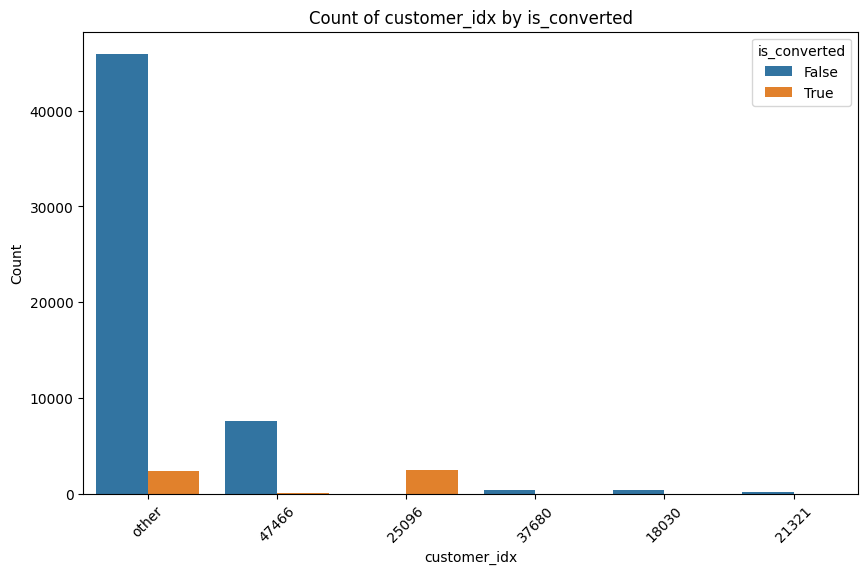

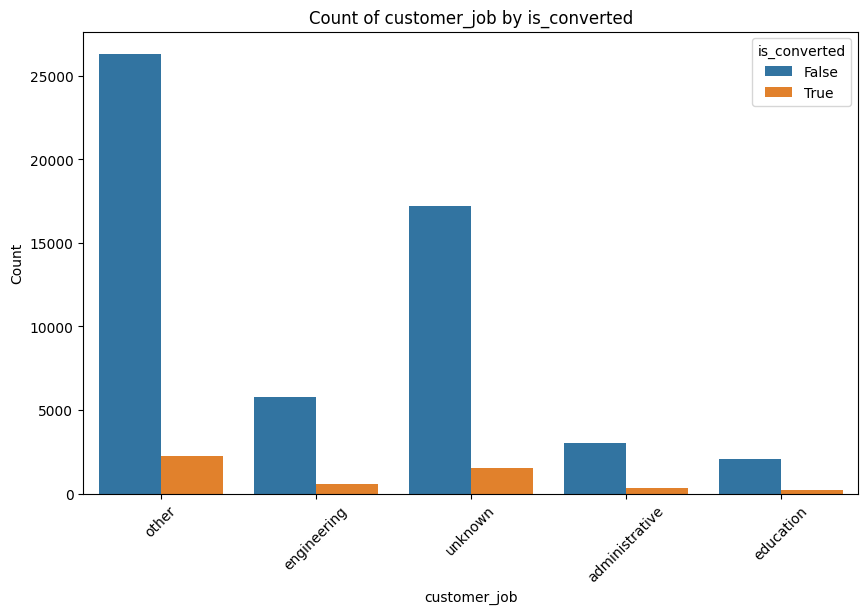

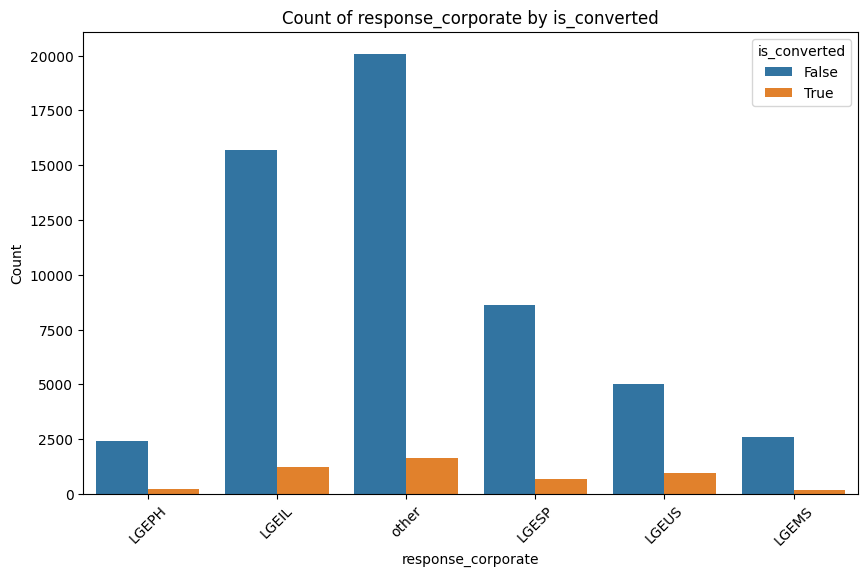

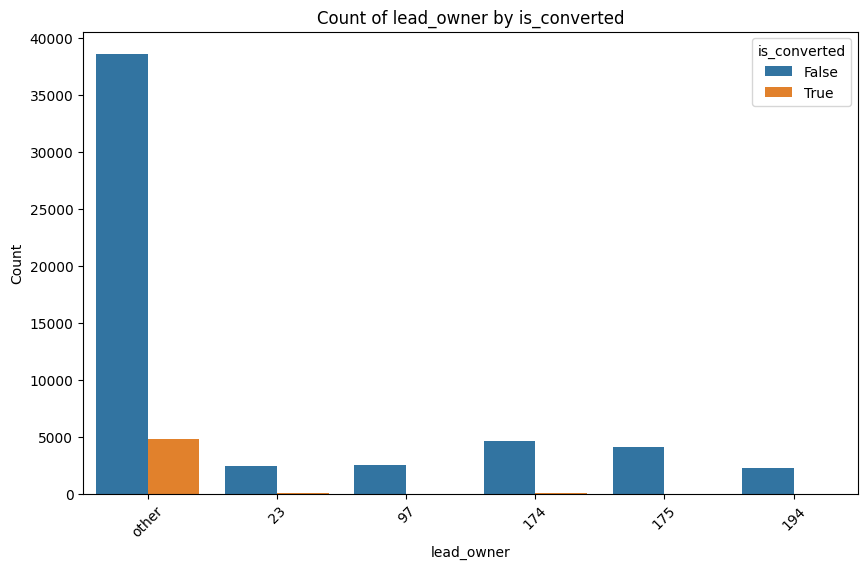

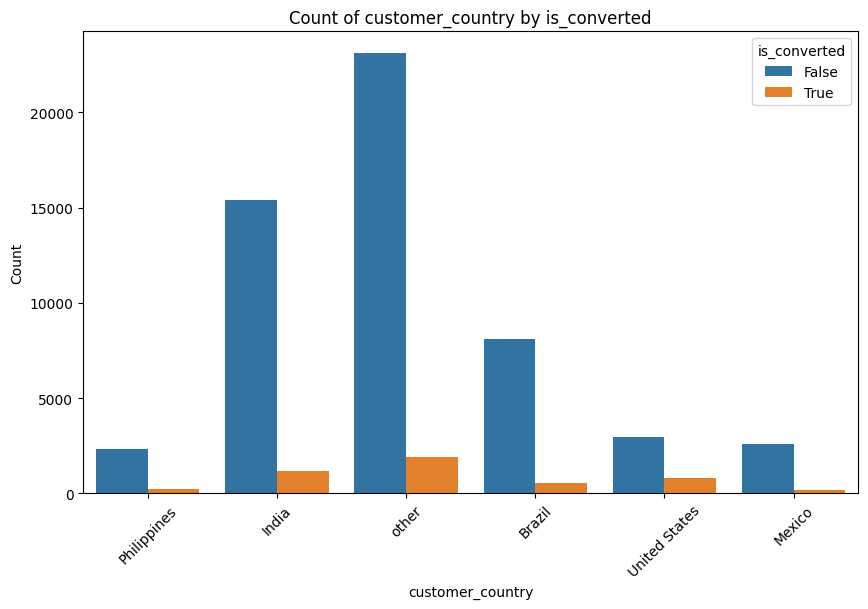

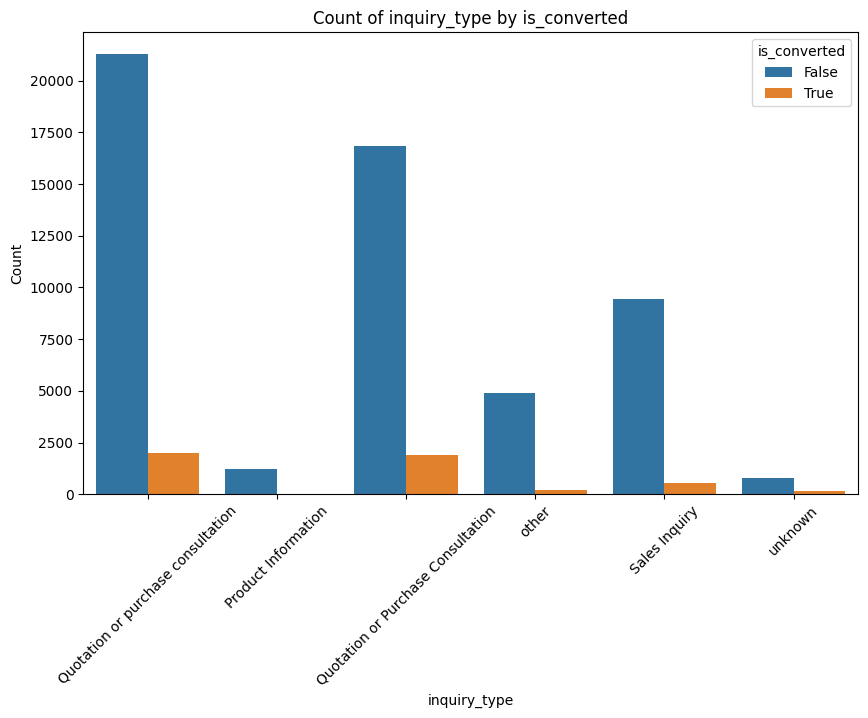

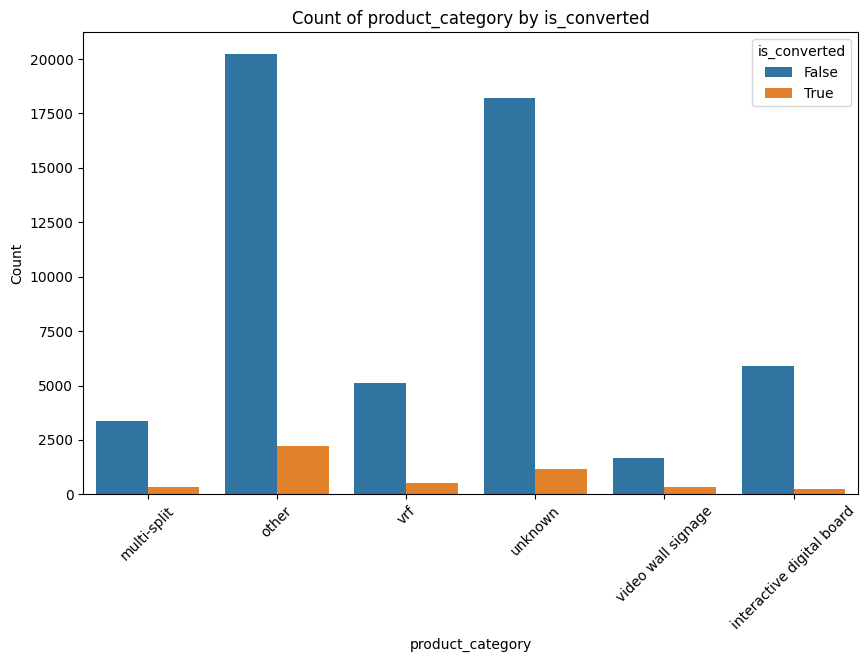

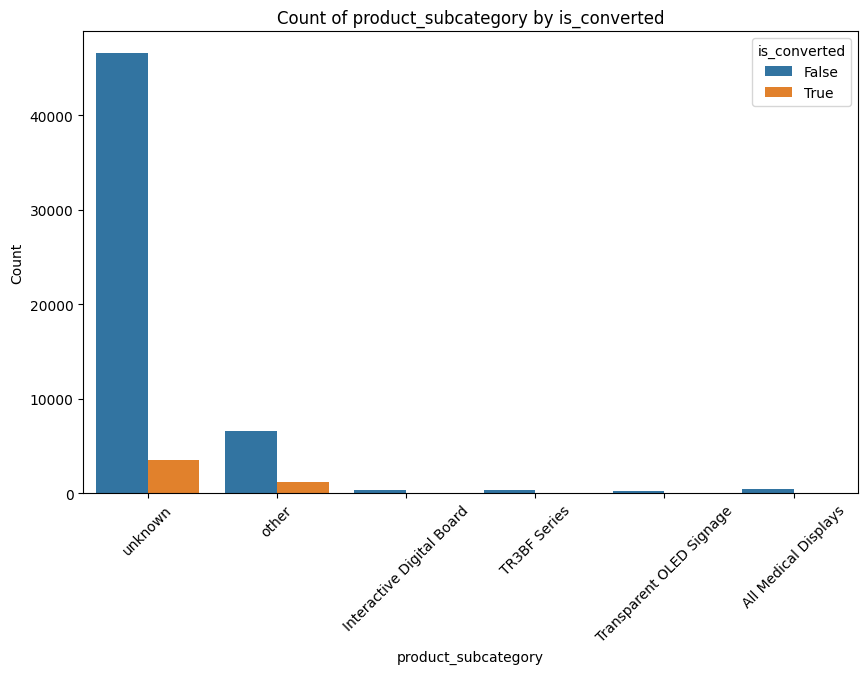

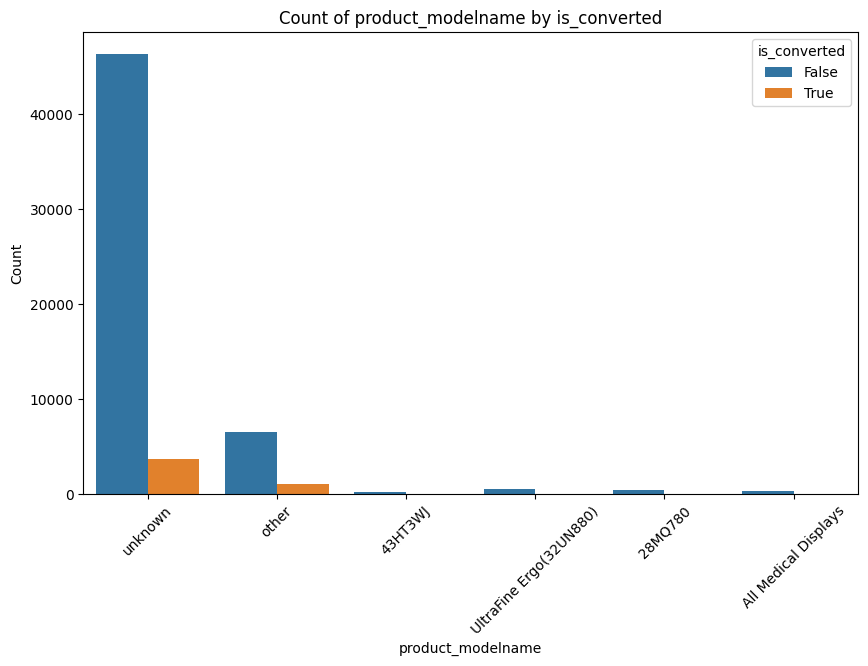

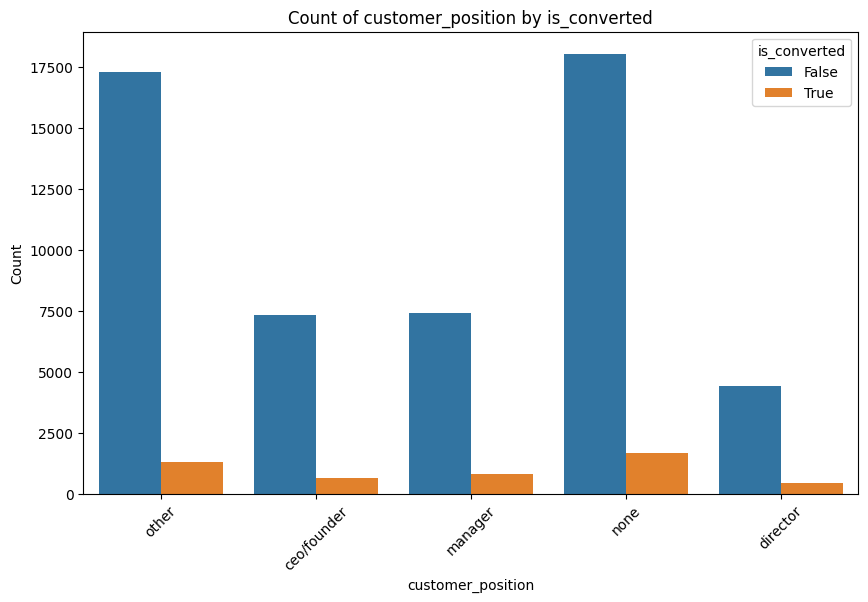

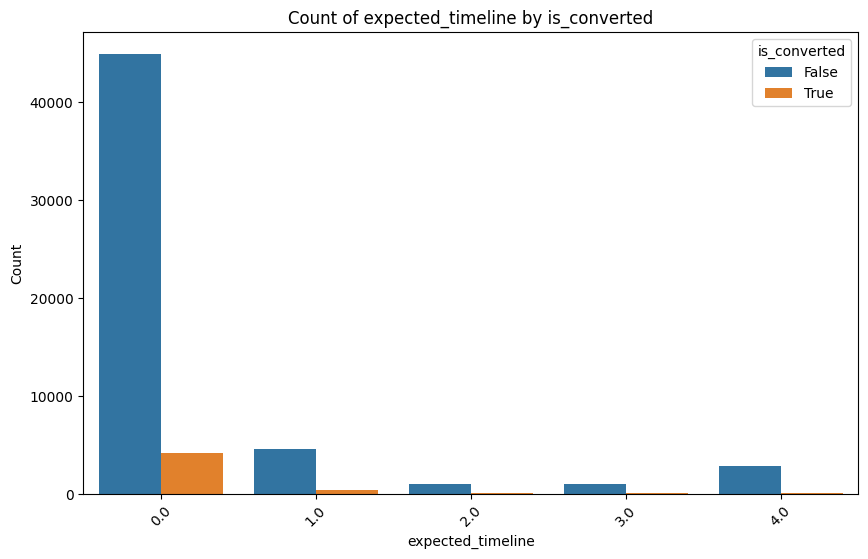

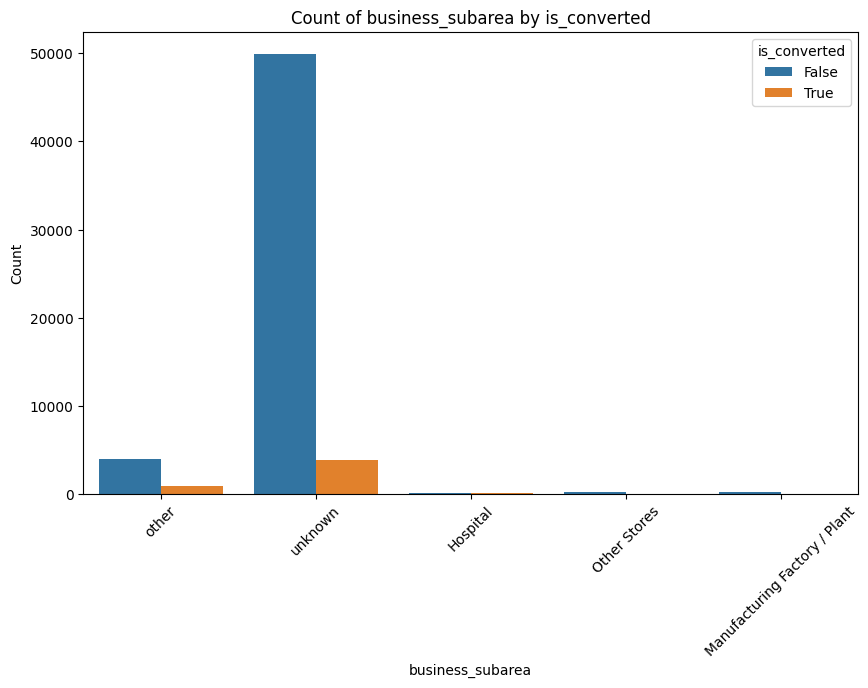

In [ ]:
import matplotlib.pyplot as plt

# 'is_converted' 값에 따른 데이터 분포 시각화
for col in toomany_categorical_col:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df_train, x=col, hue='is_converted')
    plt.title(f'Count of {col} by is_converted')
    plt.xticks(rotation=45)
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.show()


In [ ]:
df_train['lead_owner'] = df_train['lead_owner'].astype(str)
df_train['customer_idx'] = df_train['customer_idx'].astype(str)
df_test['lead_owner'] = df_test['lead_owner'].astype(str)
df_test['customer_idx'] = df_test['customer_idx'].astype(str)

필요없어보이는 column 제거하기

In [ ]:
# 도메인 지식이 있어야 필요없는걸 잘 제거할 수 있음. 근데 좀 부족한 편이어서,
# 제거했다가 포함했다가 할 수 있게 맨 마지막에 제거하는 작업을 넣었음
to_del = [
#     'customer_idx',
#     'lead_owner'
]
df_train.drop(to_del, axis=1, inplace=True)
df_test.drop(to_del, axis=1, inplace=True)

train data에서 validation data 분리하기 / test data에서 id 제거하기

In [ ]:
df_train, df_val = train_test_split(df_train, test_size=0.2)
df_test = df_test.drop('id', axis=1)

In [ ]:
# label 분리해 두기
val_labels = df_val['is_converted']
val_labels

26735    False
58330    False
22563    False
55977    False
21777    False
         ...  
32735    False
16479    False
31853     True
51588    False
1602     False
Name: is_converted, Length: 11860, dtype: bool

dataframe -> dataset

In [ ]:
# pandas dataframe을 dataset으로 변환해주는 함수
# label의 분포가 불균형하기때문에 각 batch에 true인 라벨을 포함시켜 주는게 중요하다.
# true가 0.2%인 데이터를 학습시키는 튜토리얼에서는 기본 배치 크기인 2048보다 큰 배치 크기가 적절했다.
# train set의 true는 8%정도인데, 일단 똑같이 2048로 설정해봤다.

def df_to_dataset(dataframe, shuffle=True, batch_size=2048):
  dataframe = dataframe.copy()
  labels = dataframe.pop('is_converted')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

In [ ]:
batch_size = 2048
train_ds = df_to_dataset(df_train, batch_size=batch_size)
val_ds = df_to_dataset(df_val, batch_size=batch_size)
test_ds = df_to_dataset(df_test, False, batch_size=batch_size)

모델에 넣을 수 있게 정규화 / 인코딩

In [ ]:
def get_normalization_layer(name, dataset):
  normalizer = layers.Normalization(axis=None)
  feature_ds = dataset.map(lambda x, y: x[name])
  normalizer.adapt(feature_ds)

  return normalizer

def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  if dtype == 'string':
    index = layers.StringLookup(max_tokens=max_tokens)
  else:
    index = layers.IntegerLookup(max_tokens=max_tokens)

  feature_ds = dataset.map(lambda x, y: x[name])
  index.adapt(feature_ds)

  encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size(), output_mode='one_hot')

  return lambda feature: encoder(index(feature))

In [ ]:
df_train.columns

Index(['bant_submit', 'customer_country', 'business_unit',
       'com_reg_ver_win_rate', 'customer_idx', 'customer_type', 'enterprise',
       'historical_existing_cnt', 'id_strategic_ver', 'it_strategic_ver',
       'idit_strategic_ver', 'customer_job', 'lead_desc_length',
       'inquiry_type', 'product_category', 'product_subcategory',
       'product_modelname', 'customer_country.1', 'customer_position',
       'response_corporate', 'expected_timeline', 'ver_cus', 'ver_pro',
       'ver_win_rate_x', 'ver_win_ratio_per_bu', 'business_area',
       'business_subarea', 'lead_owner', 'is_converted'],
      dtype='object')

In [ ]:
numeric_columns = ["bant_submit", "com_reg_ver_win_rate", "historical_existing_cnt", "ver_win_rate_x", "ver_win_ratio_per_bu", "lead_desc_length", "expected_timeline"]

int_categorical_columns= ["id_strategic_ver", "it_strategic_ver", "idit_strategic_ver", "ver_cus", "ver_pro"]

str_categorical_columns= ["lead_owner", "customer_idx", "customer_country", "customer_country.1", "business_subarea", "customer_job", "business_unit", "customer_type", "enterprise", "business_area", "inquiry_type", "product_category", "product_subcategory", "product_modelname", "customer_position", "response_corporate"]


In [ ]:
all_inputs = []  # 모든 입력 레이어를 저장할 리스트
encoded_features = []  # 처리된 특성을 저장할 리스트

# Numerical features.
for header in numeric_columns:  # 숫자형 특성에 대해서 반복
  # tf.keras.Input을 사용하여 특성에 대한 입력 레이어를 생성
  numeric_col = tf.keras.Input(shape=(1,), name=header)

  # 특성에 대한 정규화 레이어를 가져와서 적용
  normalization_layer = get_normalization_layer(header, train_ds)
  encoded_numeric_col = normalization_layer(numeric_col)

  # 입력 레이어와 처리된 특성을 리스트에 추가
  all_inputs.append(numeric_col)
  encoded_features.append(encoded_numeric_col)

2024-02-26 08:27:49.130230: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [47439]
	 [[{{node Placeholder/_0}}]]
2024-02-26 08:27:49.131600: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_17' with dtype double and shape [47439]
	 [[{{node Placeholder/_17}}]]
2024-02-26 08:27:50.677236: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype double and shape 

In [ ]:
for header in int_categorical_columns:
  categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='int64')
  encoding_layer = get_category_encoding_layer(name=header,
                                               dataset=train_ds,
                                               dtype='int64'
                                               )
  encoded_categorical_col = encoding_layer(categorical_col)
  all_inputs.append(categorical_col)
  encoded_features.append(encoded_categorical_col)

2024-02-26 08:27:58.819302: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_9' with dtype string and shape [47439]
	 [[{{node Placeholder/_9}}]]
2024-02-26 08:27:58.820611: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_23' with dtype string and shape [47439]
	 [[{{node Placeholder/_23}}]]
2024-02-26 08:28:00.152326: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_20' with dtype string and shape 

In [ ]:
for header in str_categorical_columns:
  categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
  encoding_layer = get_category_encoding_layer(name=header,
                                               dataset=train_ds,
                                               dtype='string'
                                               )
  encoded_categorical_col = encoding_layer(categorical_col)
  all_inputs.append(categorical_col)
  encoded_features.append(encoded_categorical_col)

2024-02-26 08:28:05.386163: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [47439]
	 [[{{node Placeholder/_1}}]]
2024-02-26 08:28:05.387715: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [47439]
	 [[{{node Placeholder/_0}}]]
2024-02-26 08:28:06.459652: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_20' with dtype string and shape [4

In [ ]:
# 마지막 layer의 bias를 설정하여 모델이 초기에 true인 모델이 얼마 없다는 것을 학습하는데 시간을 낭비하지 않도록 한다.
initial_bias = np.log([pos/neg])
initial_bias = tf.constant_initializer(initial_bias)
initial_bias

In [ ]:
all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(16, activation="relu")(all_features)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1, bias_initializer=initial_bias)(x) ##

model = tf.keras.Model(all_inputs, output)

In [ ]:
# 메트릭은 모델의 성능을 평가하는 지표이다.
# 이 데이터는 true의 비율이 8%정도밖에 안되므로, accuracy는 모델의 성능을 평가하기에 적합한 지표가 아니다.

METRICS = [
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
]

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=METRICS)

In [ ]:
weight_for_0 = (1 / neg) * (total / 2.0)  # false에 대한 가중치
weight_for_1 = (1 / pos) * (total / 2.0)  # true에 대한 가중치

weight_for_1 = weight_for_1 # * 0.8 # precision이 너무 낮아서 일부러 낮춰줬다.

class_weight = {0: weight_for_0, 1: weight_for_1}
class_weight

{0: 0.5445370897537145, 1: 6.113298969072165}

In [ ]:
baseline_history = model.fit(train_ds, epochs=50, validation_data=val_ds, class_weight=class_weight)

Epoch 1/50


2024-02-26 08:28:24.171283: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_24' with dtype int64 and shape [47439]
	 [[{{node Placeholder/_24}}]]
2024-02-26 08:28:24.172528: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype double and shape [47439]
	 [[{{node Placeholder/_14}}]]


23/24 [===========================>..] - ETA: 0s - loss: 1.0564 - accuracy: 0.9190 - precision: 0.2778 - recall: 0.0040   

2024-02-26 08:28:27.537010: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_5' with dtype string and shape [11860]
	 [[{{node Placeholder/_5}}]]
2024-02-26 08:28:27.538761: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype string and shape [11860]
	 [[{{node Placeholder/_10}}]]


24/24 [==============================] - 4s 80ms/step - loss: 1.0546 - accuracy: 0.9190 - precision: 0.2931 - recall: 0.0045 - val_loss: 0.3619 - val_accuracy: 0.9131 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
24/24 [==============================] - 1s 31ms/step - loss: 0.7739 - accuracy: 0.8587 - precision: 0.1359 - recall: 0.1409 - val_loss: 0.5460 - val_accuracy: 0.9087 - val_precision: 0.4097 - val_recall: 0.1145
Epoch 3/50
24/24 [==============================] - 2s 42ms/step - loss: 0.7023 - accuracy: 0.8107 - precision: 0.1509 - recall: 0.2922 - val_loss: 0.4924 - val_accuracy: 0.9057 - val_precision: 0.3746 - val_recall: 0.1261
Epoch 4/50
24/24 [==============================] - 2s 41ms/step - loss: 0.6500 - accuracy: 0.8516 - precision: 0.2092 - recall: 0.3035 - val_loss: 0.4437 - val_accuracy: 0.9035 - val_precision: 0.3845 - val_recall: 0.1823
Epoch 5/50
24/24 [==============================] - 2s 41ms/step - loss: 0.6070 - accuracy: 0.8559 - precision:

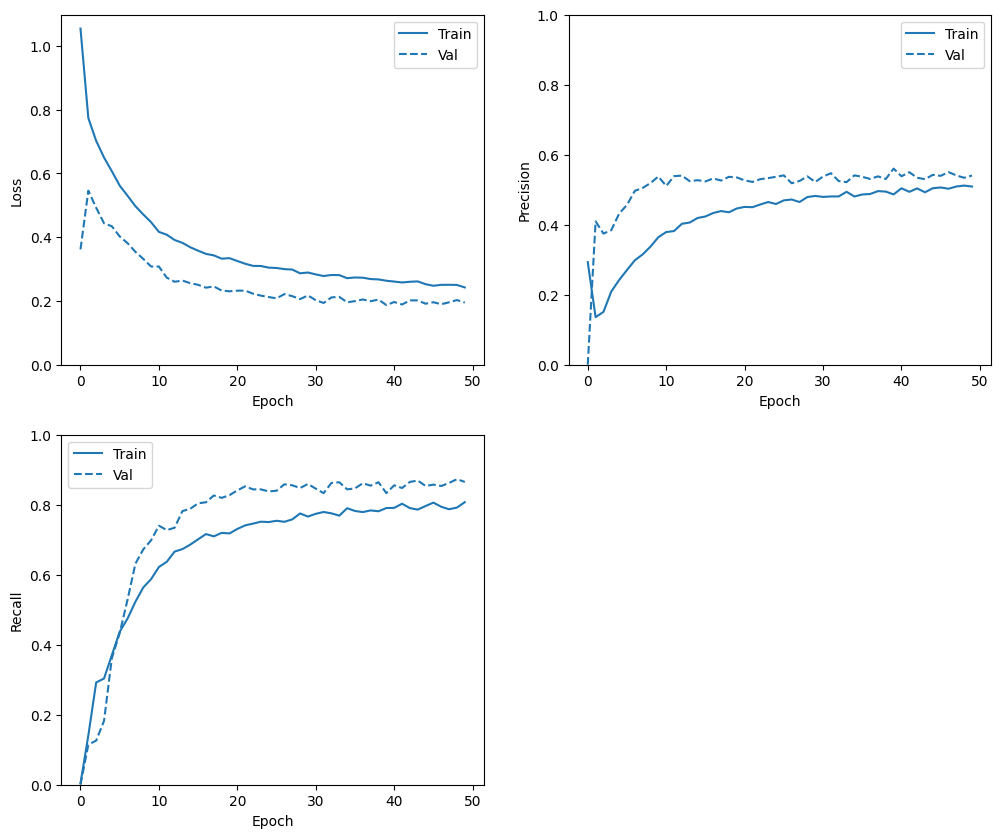

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history):
  metrics = ['loss', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()
plot_metrics(baseline_history)

In [ ]:
# 모델 평가
model.evaluate(val_ds)

6/6 [==============================] - 0s 23ms/step - loss: 0.1949 - accuracy: 0.9244 - precision: 0.5406 - recall: 0.8652


[0.1949068307876587,
 0.9243676066398621,
 0.5406060814857483,
 0.8651794195175171]

## 4. 제출하기

### 테스트 데이터 예측

In [ ]:
df_test

,bant_submit,customer_country,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,enterprise,historical_existing_cnt,id_strategic_ver,it_strategic_ver,...,response_corporate,expected_timeline,ver_cus,ver_pro,ver_win_rate_x,ver_win_ratio_per_bu,business_area,business_subarea,lead_owner,is_converted
0,0.00,Brazil,ID,0.073248,47466,End Customer,Enterprise,53.0,0.0,0.0,...,LGESP,0.0,1,0,0.001183,0.049840,retail,other,other,False
1,0.25,United States,IT,0.053892,other,End Customer,SMB,4.0,0.0,0.0,...,LGEUS,0.0,0,0,0.000013,0.053571,transportation,other,other,False
2,1.00,other,ID,0.053892,other,Specifier/ Influencer,SMB,4.0,0.0,0.0,...,other,0.0,0,0,0.000060,0.131148,hospital & health care,other,other,False
3,0.50,United States,ID,0.118644,other,unknown,Enterprise,4.0,0.0,0.0,...,LGEUS,4.0,0,0,0.001183,0.049840,retail,unknown,194,False
4,1.00,Brazil,ID,0.074949,other,End Customer,Enterprise,2.0,1.0,0.0,...,LGESP,0.0,1,1,0.003079,0.064566,corporate / office,other,other,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5266,0.50,other,AS,0.053892,other,unknown,Enterprise,10.0,0.0,0.0,...,LGESP,0.0,0,0,0.000572,0.053571,unknown,unknown,97,False
5267,0.25,United States,IT,0.053892,47466,unknown,Enterprise,0.0,0.0,0.0,...,LGEUS,0.0,0,0,0.000572,0.053571,unknown,unknown,other,False
5268,0.75,Brazil,AS,0.053892,other,Specifier/ Influencer,Enterprise,4.0,0.0,0.0,...,LGESP,0.0,0,0,0.000572,0.053571,unknown,unknown,97,False
5269,0.00,other,IT,0.053892,other,End Customer,SMB,4.0,0.0,0.0,...,other,0.0,0,0,0.000572,0.053571,unknown,unknown,other,False


In [ ]:
test_pred = model.predict(test_ds)
test_pred = np.where(test_pred >= 0, True, False)

3/3 [==============================] - 0s 26ms/step


2024-02-26 08:29:47.812744: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_17' with dtype double and shape [5271]
	 [[{{node Placeholder/_17}}]]


In [ ]:
test_pred

array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]])

In [ ]:
test_pred = test_pred.flatten()
test_pred

array([False, False, False, ..., False, False, False])

In [ ]:
sum(test_pred) # True로 예측된 개수

991

### 제출 파일 작성

In [ ]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["is_converted"] = test_pred

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)

**우측 상단의 제출 버튼을 클릭해 결과를 확인하세요**